In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hyperparameter search with threshold-dependent metrics

In a binary classification problem, you probably shouldn't ever use the `.predict` method from scikit-learn (and consequently from libraries that follow [its design pattern](https://scikit-learn.org/stable/developers/develop.html)). In scikit-learn, the implementation of `.predict`, in general, follows the logic [implemented](https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/ensemble/_forest.py#L800-L837) for [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

```python
def predict(self, X):
    ...
    proba = self.predict_proba(X)
    ...
    return self.classes_.take(np.argmax(proba, axis=1), axis=0)
```

In the case where we only have two classes (0 or 1), the `.predict`, when picking the class with the highest "probability", is equivalent to the rule " if `.predict_proba > 0.5`, then predict `1`; otherwise, predict `0`". That is, under the hood, we are using a threshold of `0.5` without having visibility.

Up to now, nothing new. However, I will show in an example how this can be harmful to superficial analyzes that don't take this into account.

___

## Optimizing f1 in a naive way

To exemplify this issue, I will use a dataset from [imbalanced-learn](https://imbalanced-learn.org/stable/), a library with several implementations of techniques that deal with imbalanced problems, from the [scikit-learn-contrib](https://github.com/scikit-learn-contrib) environment. And let's build a model that ideally has the best possible [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [2]:
from imblearn.datasets import fetch_datasets

dataset = fetch_datasets()["coil_2000"]
X, y = dataset.data, (dataset.target==1).astype(int)

print(f"Percentage of y=1 is {np.round(y.mean(), 5)*100}%.")
print(f"Number of rows is {X.shape[0]}.")

Percentage of y=1 is 5.966%.
Number of rows is 9822.


I'm going to divide the dataset (taking care of the stratification because we are in an imbalanced problem) into a part for training the model, a second for choosing the threshold, and a last one for validation. We will not be dealing with the second part for now, but I will show some ways of optimizing the threshold that will need this extra set.

In [3]:
from sklearn.model_selection import train_test_split

X_train_model, X_test, y_train_model, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train_model, X_train_threshold, y_train_model, y_train_threshold = \
train_test_split(X_train_model, y_train_model, random_state=0, stratify=y_train_model)

Suppose we want to optimize the hyperparameters of a [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) getting the best possible [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) (as we anticipated just now).

I'm going to create an auxiliary function to run this search for hyperparameters because we're going to do this sometimes (using a [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), but it could be any other way to search for hyperparameters).

In [4]:
from sklearn.model_selection import StratifiedKFold

params = {
    "max_depth": [2, 4, 10, None],
    "n_estimators": [10, 50, 100],
}

skfold = StratifiedKFold(n_splits=3,
                         shuffle=True,
                         random_state=0)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def run_experiment(estimator, scoring, X, y, params, cv):
    gscv = (
        GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring=scoring,
                     cv=cv)
        .fit(X, y)
    )

    return (
        pd.DataFrame(gscv.cv_results_)
        .pipe(lambda df:
              df[list(map(lambda x: "param_" + x,  params.keys())) + ["mean_test_score", "std_test_score"]])
    )

With this auxiliary function built, we run our search trying to optimize `scoring="f1"`.

In [6]:
run_experiment(estimator=RandomForestClassifier(random_state=0),
               scoring="f1", X=X_train_model, y=y_train_model, params=params, cv=skfold)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,2,10,0.000000,0.000000
1,2,50,0.000000,0.000000
2,2,100,0.000000,0.000000
3,4,10,0.000000,0.000000
4,4,50,0.000000,0.000000
5,4,100,0.000000,0.000000
6,10,10,0.059510,0.039552
7,10,50,0.040333,0.016119
8,10,100,0.034938,0.014265
9,None,10,0.097418,0.007834


Some combinations of hyperparameters seem to have an [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) of 0. Weird.

This happens because as [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is a threshold-dependent metric (in the sense that it needs hard predictions instead of predicted probabilities), scikit-learn understands that it needs to use `.predict` instead of `.predict_proba` (and consequently "uses the threshold of `0.5`", as we discussed the equivalence earlier).

As our problem is imbalanced, a threshold of `0.5` usually is suboptimal. And that's the case. We will have a considerable accumulation of `.predict_proba` close to 0 in almost any model, and, probably, a threshold closer to `0` in our problem seems more reasonable.

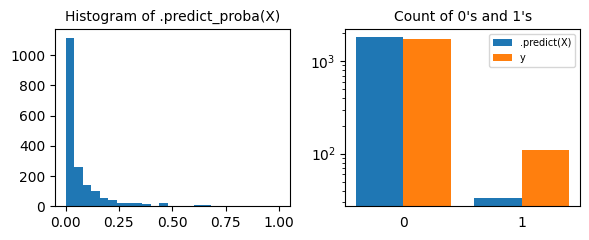

In [7]:
from collections import Counter
out_of_the_box_model = RandomForestClassifier(random_state=0).fit(X_train_model, y_train_model)

predict_proba = out_of_the_box_model.predict_proba(X_train_threshold)[:, 1]
predict = out_of_the_box_model.predict(X_train_threshold)

# Just to check. ;)
assert ((predict_proba > 0.5).astype(int) == predict).all()

fig, ax = plt.subplots(ncols=2, figsize=(6, 2.5))

ax[0].hist(predict_proba, bins=np.linspace(0, 1, 26))
ax[0].set_title("Histogram of .predict_proba(X)", fontsize=10)

count_predict = Counter(predict)
ax[1].bar(count_predict.keys(), count_predict.values(), label=".predict(X)", width=0.4)
count_y = Counter(y_train_threshold)
ax[1].bar(np.array(list(count_y.keys())) + 0.4, count_y.values(), label="y", width=0.4)
ax[1].set_xticks([0.2, 1.2])
ax[1].set_xticklabels([0, 1])
ax[1].tick_params(bottom = False)
ax[1].set_yscale("log")
ax[1].set_title("Count of 0's and 1's", fontsize=10)
ax[1].legend(fontsize=7)

plt.tight_layout()

Very few examples pass the `0.5` threshold, a significantly lower amount than the actual number of class 1 samples. This tells us that a softer threshold (less than `0.5`) makes more sense in this problem.

This is often the case in imbalanced learning scenarios. For instance, if you have 1% of people with some disease in your population and your model predicts that this person has a 10% chance of having that disease, then chances are that you should treat him as someone with a high likelihood of being ill.

___

## Tuning the threshold

To find the optimal threshold, we can [bootstrap](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf) a set separate from the one used in training to find the best threshold for that model by optimizing some metric (threshold-dependent) of interest, such as, in our case, [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [8]:
from tqdm import tqdm

def optmize_threshold_metric(model, X, y, metric, threshold_grid, n_bootstrap=20):
    metric_means, metric_stds = [], []
    for t in tqdm(threshold_grid):
        metrics = []
        for i in range(n_bootstrap):
            ind_bootstrap = np.random.RandomState(i).choice(len(y), len(y), replace=True)
            metric_val = metric(y[ind_bootstrap],
                          (model.predict_proba(X[ind_bootstrap])[:, 1] > t).astype(int))
            metrics.append(metric_val)
        metric_means.append(np.mean(metrics))
        metric_stds.append(np.std(metrics))

    metric_means, metric_stds = np.array(metric_means), np.array(metric_stds)
    best_threshold = threshold_grid[np.argmax(metric_means)]

    return metric_means, metric_stds, best_threshold

For each threshold value, we estimate the mean of [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) that we expect to obtain with that choice if we run the experiment different times through the bootstrap and the standard deviation to get an idea of the variance of the [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) we got. We chose the final threshold as the one with the best-estimated [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

100%|██████████| 101/101 [02:00<00:00,  1.19s/it]


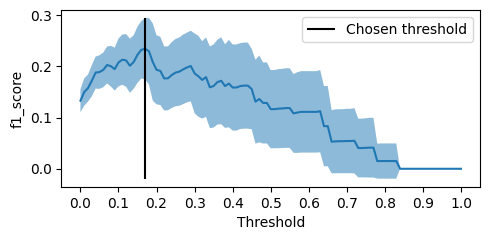

In [9]:
threshold_grid = np.linspace(0, 1, 101)
from sklearn.metrics import f1_score

f1_means_ootb, f1_stds_ootb, best_threshold_ootb = \
optmize_threshold_metric(out_of_the_box_model, X_train_threshold, y_train_threshold, f1_score, threshold_grid)

fig, ax = plt.subplots(figsize=(5, 2.5))
ax.plot(threshold_grid, f1_means_ootb)
ax.fill_between(threshold_grid, f1_means_ootb - 1.96 * f1_stds_ootb, f1_means_ootb + 1.96 * f1_stds_ootb, alpha=0.5)
ax.vlines(best_threshold_ootb, min(f1_means_ootb - 1.96 * f1_stds_ootb), max(f1_means_ootb + 1.96 * f1_stds_ootb), "k", label="Chosen threshold")
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel("Threshold")
ax.set_ylabel("f1_score")
ax.legend()
plt.tight_layout()

In [10]:
f1_score(y_test, (out_of_the_box_model.predict_proba(X_test)[:, 1] > best_threshold_ootb).astype(int))

0.1878453038674033

In [11]:
f1_score(y_test, out_of_the_box_model.predict(X_test))

0.043478260869565216

With the threshold chosen through optimization, we ended up with a much better [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) than the one we get with `.predict`, with the `0.5` threshold.

$\oint$ _Here we are directly choosing the threshold that, on average, has the best metric value of interest, but there are other possibilities [[1](#bibliography)]. We could, for example, play with the "confidence interval" (which, in this case, I'm just plotting to give an order of magnitude of the variance), optimizing for the upper or lower limit, or even use the threshold that maximizes [Youden's J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic) (which is equivalent to taking the threshold that gives the most significant separation of the KS curves between the `.predict_proba(X[y==0])` and `.predict_proba(X[y==1])`._


___

## Back to hyperparameters search

But what to do now? How can we get around this if optimizing the [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) directly doesn't look like a good idea since scikit-learn will use `.predict`? We will discuss three possibilities of how to get around this issue. One case is not necessarily better than the other, and the idea is to show some options for facing the problem.

### 1. Optimizing a metric that works and is related to the desired metric

The most applied way in the market is, even if you are interested in the threshold-dependent metric, to use a threshold-independent metric to do this optimization and only, in the end, use something like `optmize_threshold_metric` to optimize the metric of genuine interest.

$\oint$ _This sounds sub-optimal, but we do this all the time in Machine Learning. Even if you're interested in optimizing [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) on a credit default classification problem, your [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) will be optimizing for `criterion="gini"` or something related to [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), but that is different. Here the idea is the same. Optimizing for [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) or [`sklearn.metrics.average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) is not the same as optimizing for [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), for example, but models that are good at the former will be good at the latter too._

In [12]:
run_experiment(estimator=RandomForestClassifier(random_state=0),
               scoring="roc_auc", X=X_train_model, y=y_train_model, params=params, cv=skfold)

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,2,10,0.719377,0.008165
1,2,50,0.746675,0.007476
2,2,100,0.742196,0.007105
3,4,10,0.733715,0.013691
4,4,50,0.744482,0.010491
5,4,100,0.747113,0.007466
6,10,10,0.695511,0.018646
7,10,50,0.703767,0.019845
8,10,100,0.708600,0.022674
9,None,10,0.652099,0.031056


### 2. Leak the threshold search

But what if we want to explicitly optimize our interest metric within the grid search for some reason? In that case, we need to make a bigger workaround. A reasonable proxy of how your model will perform when you optimize the threshold is to optimize the threshold on your test set. In this case, as you will choose the threshold that will optimize the metric in the validation set, your metric will be the best possible, and you can directly take the `max` or the `min`.

In [13]:
from sklearn.metrics import make_scorer

def make_threshold_independent(metric, threshold_grid=np.linspace(0, 1, 101), greater_is_better=True):
    opt_fun = {True: max, False: min}
    opt = opt_fun[greater_is_better]
    def threshold_independent_metric(y_true, y_pred, *args, **kwargs):
        return opt([metric(y_true, (y_pred > t).astype(int), *args, **kwargs) for t in threshold_grid])
    return threshold_independent_metric

f1_threshold_independent_score = make_threshold_independent(f1_score)
f1_threshold_independent_scorer = make_scorer(f1_threshold_independent_score, needs_proba=True)

As this is a threshold-independent metric (because we passed `needs_proba=True`), we will no longer have the problem of scikit-learn using `.predict`.

In [14]:
df_best_f1 = run_experiment(estimator=RandomForestClassifier(random_state=0),
                            scoring=f1_threshold_independent_scorer,
                            X=X_train_model, y=y_train_model, params=params, cv=skfold)

df_best_f1

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,2,10,0.253281,0.009199
1,2,50,0.267678,0.005953
2,2,100,0.257495,0.002502
3,4,10,0.241877,0.017142
4,4,50,0.257753,0.014293
5,4,100,0.263571,0.011393
6,10,10,0.202218,0.016497
7,10,50,0.225597,0.032149
8,10,100,0.230246,0.025504
9,None,10,0.181869,0.015010


On the other hand, we are leaking our model and consequently overestimating our metric since we are choosing the best threshold in the cross-validation validation set.

### 3. Tuning the threshold during gridsearch on a chunk of the training set

A better way to do this (in terms of correctly evaluating the performance during cross-validation) is to modify our estimator's training function so that it also calculates the best threshold.  To clarify what we are doing without having to look at the class details I will implement, it is worth comparing the difference between the method 2 and method 3.

In each step of our cross-validation, we will have a training set and a set validation that we will use to evaluate the performance of the classifier trained in that training set. That is what we were doing during method 1, for instance.

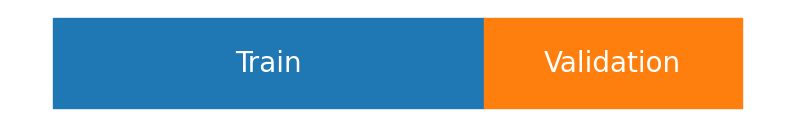

In [15]:
fig, ax = plt.subplots(figsize=(10, 1.4))
ax.fill_between([0, 1], 2*[0], 2*[1], color="C0")
ax.fill_between([1, 1.6], 2*[0], 2*[1], color="C1")
ax.set_xlim([-0.1, 1.7])
ax.set_ylim([-0.1, 1.1])
ax.text(0.5, 0.5, "Train", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.text(1.3, 0.5, "Validation", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.axis("off")
plt.show()

In solution 2, we optimize the threshold on the validation set by taking the best possible metric value for the different thresholds of our threshold grid. But, as we are leaking the threshold search, we will overestimate our metric, which can be harmful.

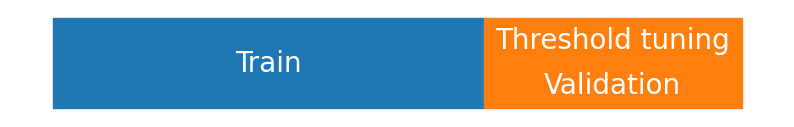

In [16]:
fig, ax = plt.subplots(figsize=(10, 1.4))
ax.fill_between([0, 1], 2*[0], 2*[1], color="C0")
ax.fill_between([1, 1.6], 2*[0], 2*[1], color="C1")
ax.set_xlim([-0.1, 1.7])
ax.set_ylim([-0.1, 1.1])
ax.text(0.5, 0.5, "Train", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.text(1.3, 0.75, "Threshold tuning", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.text(1.3, 0.25, "Validation", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.axis("off")
plt.show()

In the solution we are discussing, during the training stage, we will do a hold-out to have a set that we will use to optimize the threshold, and the optimal threshold will be used in the validation evaluation.

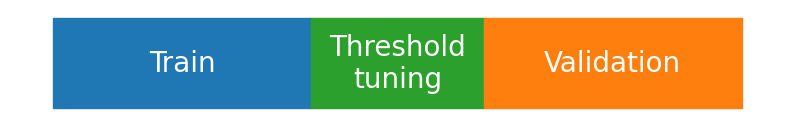

In [17]:
fig, ax = plt.subplots(figsize=(10, 1.4))
ax.fill_between([0, 0.6], 2*[0], 2*[1], color="C0")
ax.fill_between([0.6, 1], 2*[0], 2*[1], color="C2")
ax.fill_between([1, 1.6], 2*[0], 2*[1], color="C1")
ax.set_xlim([-0.1, 1.7])
ax.set_ylim([-0.1, 1.1])
ax.text(0.3, 0.5, "Train", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.text(0.8, 0.5, "Threshold\ntuning", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.text(1.3, 0.5, "Validation", horizontalalignment="center", verticalalignment="center", color="w", fontsize=20)
ax.axis("off")
plt.show()

A rough implementation of a class that does this logic is as follows:

In [18]:
import inspect
def dic_without_keys(dic, keys):
    return {x: dic[x] for x in dic if x not in keys}

class ThresholdOptimizerRandomForestBinaryClassifier(RandomForestClassifier):

    def __init__(self, n_bootstrap=20, metric=f1_score, threshold_grid=np.linspace(0, 1, 101), *args, **kwargs,):

        kwargs_without_extra = dic_without_keys(kwargs, ("n_bootstrap", "metric", "threshold_grid"))
        super().__init__(*args, **kwargs_without_extra)
        self.metric = metric
        self.threshold_grid = threshold_grid
        self.n_bootstrap = n_bootstrap

    @classmethod
    def _get_param_names(cls):
        init = getattr(super().__init__, "deprecated_original", super().__init__)
        init_signature = inspect.signature(init)
        parameters = [p for p in init_signature.parameters.values() if p.name != "self" and p.kind != p.VAR_KEYWORD]
        return sorted([p.name for p in parameters] + ["n_bootstrap", "metric", "threshold_grid"])

    def fit(self, X, y, sample_weight=None):

        X_train_model, X_train_threshold, y_train_model, y_train_threshold = \
        train_test_split(X, y, random_state=self.random_state, stratify=y)

        super().fit(X_train_model, y_train_model, sample_weight=sample_weight)
        _, _, self.best_threshold_ = self.optmize_threshold_metric(X_train_threshold, y_train_threshold)

        return self

    def optmize_threshold_metric(self, X, y):
        metric_means, metric_stds = [], []
        for t in self.threshold_grid:
            metrics = []
            for i in range(self.n_bootstrap):
                ind_bootstrap = np.random.RandomState(i).choice(len(y), len(y), replace=True)
                metric_val = self.metric(y[ind_bootstrap],
                                         (self.predict_proba(X[ind_bootstrap])[:, 1] > t).astype(int))
                metrics.append(metric_val)
            metric_means.append(np.mean(metrics))
            metric_stds.append(np.std(metrics))

        metric_means, metric_stds = np.array(metric_means), np.array(metric_stds)
        best_threshold = self.threshold_grid[np.argmax(metric_means)]

        return metric_means, metric_stds, best_threshold

    def predict(self, X):
        preds = self.predict_proba(X)[:, 1]
        return (preds > self.best_threshold_).astype(int)

$\oint$ *[scikit-learn doesn't like you using `args` and `kwargs` on your estimator's `init`](https://scikit-learn.org/stable/developers/develop.html#instantiation) because of how they designed the way they deal with hyperparameter optimization. But as I didn't want my `init` to [look like this](https://github.com/vitaliset/blog-notebooks/blob/700ce6ed6f61952db3f54c2f149fda5fc36175e9/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py#L52-L71), I decided to change the [`_get_param_names`](https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/base.py#L122-L151) from the [`sklearn.base.BaseEstimator`](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) to call only the parameters of the class I'm inheriting from ([`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a.k.a. `super()`). If you want to design it properly, you should do [this](https://github.com/vitaliset/blog-notebooks/blob/700ce6ed6f61952db3f54c2f149fda5fc36175e9/DataLab_Blog_Boruta_2022_09_05/shap_feature_importances_.py#L52-L71).*

$\oint$ *Note that although I'm inheriting from [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), I don't use any [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)-specific logic here, and actually, you can do the same with any scikit-learn estimator.* 

We are basically using the same optimization function we had discussed earlier on the part of the set that is given in `.fit` by doing a [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). This implementation is computationally expensive, mainly because of bootstrap. So I lowered the number of bootstrap samples to make it faster.

In [19]:
%%time

df_best = run_experiment(
    estimator=ThresholdOptimizerRandomForestBinaryClassifier(random_state=0, n_bootstrap=5,
                                                             metric=f1_score, threshold_grid=threshold_grid),
    scoring="f1", X=X_train_model, y=y_train_model, params=params, cv=skfold)

df_best

CPU times: total: 5min 25s
Wall time: 5min 28s


,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,2,10,0.238970,0.011282
1,2,50,0.238447,0.016450
2,2,100,0.243230,0.022790
3,4,10,0.203598,0.039442
4,4,50,0.226371,0.023246
5,4,100,0.249048,0.007759
6,10,10,0.200635,0.034000
7,10,50,0.199724,0.050758
8,10,100,0.176026,0.042777
9,None,10,0.175387,0.015105


___

## Tuning the threshold for the best hyperparameters combination

With this best combination of hyperparameters of method 3 chosen, we can do the procedure we discussed earlier to find the best threshold for this model.

In [20]:
best_params_values = df_best.sort_values("mean_test_score", ascending=False).iloc[0][list(map(lambda x: "param_" + x,  params.keys()))].values
best_params = dict(zip(params.keys(), best_params_values))
best_params

{'max_depth': 4, 'n_estimators': 100}

In [21]:
best_model = (
    RandomForestClassifier(random_state=0)
    .set_params(**best_params)
    .fit(X_train_model, y_train_model)
)

100%|██████████| 101/101 [01:13<00:00,  1.37it/s]


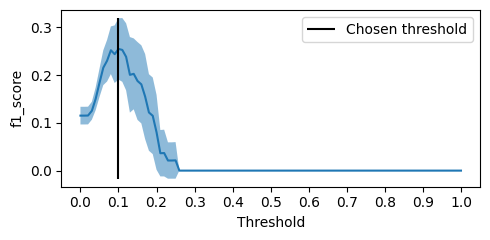

In [22]:
f1_means_best, f1_stds_best, best_threshold_best = \
optmize_threshold_metric(best_model, X_train_threshold, y_train_threshold, f1_score, threshold_grid)

fig, ax = plt.subplots(figsize=(5, 2.5))
ax.plot(threshold_grid, f1_means_best)
ax.fill_between(threshold_grid, f1_means_best - 1.96 * f1_stds_best, f1_means_best + 1.96 * f1_stds_best, alpha=0.5)
ax.vlines(best_threshold_best, min(f1_means_best - 1.96 * f1_stds_best), max(f1_means_best + 1.96 * f1_stds_best), "k", label="Chosen threshold")
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel("Threshold")
ax.set_ylabel("f1_score")
ax.legend()
plt.tight_layout()

In [23]:
f1_score(y_test, (best_model.predict_proba(X_test)[:, 1] > best_threshold_best).astype(int))

0.24038461538461534

In [24]:
f1_score(y_test, best_model.predict(X_test))

0.0

Notice that we got a much better [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) than the initial search was telling us we would get!

___

## tl;dr

When optimizing hyperparameters, threshold-dependent metrics make [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)-like search methods use the estimator's `.predict` method instead of `.predict_proba`. This can be harmful as `0.5` might not be the best threshold, especially in imbalanced learning scenarios.

Always prioritize the threshold-independent metrics, but if you need to use a threshold-dependent metric, you can try to make it threshold-independent by getting the optimal value for it (`max` or `min` depending on if `greater_is_better=True` or `False`) for a threshold grid of options. As this is the same as optimizing it for the validation set, it can slightly overestimate your results.

A more honest way to do this is to explicitly optimize the threshold on a part of your training set for each cross-validation fold. This mimics reality better but is more time-consuming as this optimization takes time if you want it to be robust (for instance, using bootstrap to estimate better the performance value).

$\oint$ *This is the current state of this topic, in version 1.2.0 of scikit-learn. In a future release, there will be a `sklearn.model_selection.CutoffClassifier` (from [PR #16525](https://github.com/scikit-learn/scikit-learn/pull/16525)) that will behave very closely to my `ThresholdOptimizerRandomForestBinaryClassifier`. One significant change will be that it will receive the estimator during initialization instead of inheriting it.*

## <a name="bibliography">Bibliography</a>

[1] [A Gentle Introduction to Threshold-Moving for Imbalanced Classification by Jason Brownlee.](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)
